# Train small Splicevo model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tqdm
import os

## Simulate small dataset

To train a Splicevo model, we need the following data:

- Input DNA sequences of shape `B, L, 4` (one-hot encoded)
- Labels of shape `B, L` corresponding to splice site annotations (0=not a splice site, 1=splice donor, 2=splice acceptor)
- SSE values of shape `B, L, N` correspondint to splice site strength estimates in N different conditions (tissues, developmental time points)
- Species vector of length `B` indicating the species for each sequence in the batch
- Mappings of species indices to species names, and condition indices to condition names

`B` is the batch size, `L` is the sequence length (consisting of core sequence `core_len` and `context_len` on both sides), and `N` is the number of conditions.

In [2]:
# Simulate small dataset
B = 4000
L = 3000
context_len = 500
core_len = L - 2 * context_len
N = 5

# Simulate random sequence input
sequences = np.random.randint(0, 2, size=(B, L, 4)).astype(np.float32)

# Simulate species assignment
species = np.random.randint(0, 3, size = B).astype(np.int32)

# Insert splice sites into random sequences
def insert_splice_sites(sequences, donor_freq=0.01, acceptor_freq=0.01):
    B = sequences.shape[0]
    L = sequences.shape[1]
    labels = np.zeros((B, L), dtype=np.int64)
    for b in range(sequences.shape[0]):
        donor_sites = np.random.randint(2, L, int(donor_freq * L))
        acceptor_sites = np.random.randint(2, L, int(acceptor_freq * L))
        for pos in donor_sites:
            labels[b, pos] = 1
            sequences[b, pos-2:pos, :] = [[0, 0, 1, 0],[0, 0, 0, 1]]  # 'GT' donor site
        for pos in acceptor_sites:
            labels[b, pos] = 2
            sequences[b, pos-2:pos, :] = [[1, 0, 0, 0],[0, 0, 1, 0]]  # 'AG' acceptor site
    return sequences, labels

sequences, labels = insert_splice_sites(sequences)

# Print number of sites per species
for i in np.unique(species):
    labels_i = labels[species == i]
    print(f"Species {i}: {labels_i.shape[0]} sequences" )
    for site_type in range(3):
        print(f"  site type {site_type}: {labels_i[labels_i == site_type].shape[0]}")

Species 0: 1355 sequences
  site type 0: 3984482
  site type 1: 40040
  site type 2: 40478
Species 1: 1311 sequences
  site type 0: 3855118
  site type 1: 38741
  site type 2: 39141
Species 2: 1334 sequences
  site type 0: 3922759
  site type 1: 39405
  site type 2: 39836


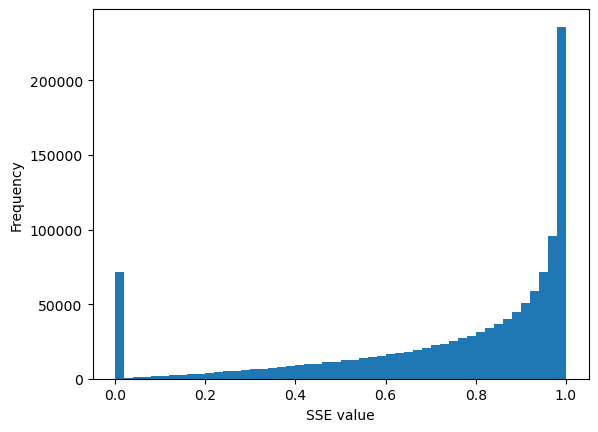

In [3]:
# Simulate SSE values distribution 
sse = np.random.beta(2, 0.5, size=(B, L, N)).astype(np.float32)
# Set non-splice positions to zero SSE
sse[labels == 0] = 0
# Set a fraction of splice positions to zero SSE
splice_positions = np.where(labels > 0)
num_zero_sse = int(0.3 * len(splice_positions[0]))
zero_sse_indices = np.random.choice(len(splice_positions[0]), num_zero_sse, replace=False)
sse[splice_positions[0][zero_sse_indices], splice_positions[1][zero_sse_indices], np.random.randint(0, N, size=1)] = 0

# Plot SSE distribution
import matplotlib.pyplot as plt
plt.hist(sse[labels > 0].flatten(), bins=50)
plt.xlabel('SSE value')
plt.ylabel('Frequency')
plt.show()

Split dataset into train (80%) and test (20%)

In [4]:
# Train/test/validation split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split into train+val and test (80/20)
train_val_idx, test_idx = train_test_split(
    np.arange(len(sequences)),
    test_size=0.2,
    random_state=42
)

# Split train+val into train and validation (80/20 of train+val = 64/16 overall)
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.2,
    random_state=42
)

print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

# Create train, validation, and test sets
train_sequences, train_labels, train_sse, train_species = (
    sequences[train_idx], labels[train_idx], sse[train_idx], species[train_idx]
)
val_sequences, val_labels, val_sse, val_species = (
    sequences[val_idx], labels[val_idx], sse[val_idx], species[val_idx]
)
test_sequences, test_labels, test_sse, test_species = (
    sequences[test_idx], labels[test_idx], sse[test_idx], species[test_idx]
)

# Create datasets
from splicevo.training import SpliceDataset

train_dataset = SpliceDataset(train_sequences, train_labels, train_sse, train_species)
val_dataset = SpliceDataset(val_sequences, val_labels, val_sse, val_species)
test_dataset = SpliceDataset(test_sequences, test_labels, test_sse, test_species)

# Create data loaders
batch_size = 16
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("\nData loaders created successfully!")

Train set size: 2560
Validation set size: 640
Test set size: 800


/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Data loaders created successfully!


In [5]:
# Count splice sites in each set
def count_splice_sites(labels):
    donor_count = np.sum(labels == 1)
    acceptor_count = np.sum(labels == 2)
    return donor_count, acceptor_count
train_donors, train_acceptors = count_splice_sites(train_labels)
val_donors, val_acceptors = count_splice_sites(val_labels)
test_donors, test_acceptors = count_splice_sites(test_labels)
print(f"Train set: {train_donors} donors, {train_acceptors} acceptors")
print(f"Validation set: {val_donors} donors, {val_acceptors} acceptors")
print(f"Test set: {test_donors} donors, {test_acceptors} acceptors")

Train set: 75690 donors, 76454 acceptors
Validation set: 18891 donors, 19099 acceptors
Test set: 23605 donors, 23902 acceptors


In [6]:
# Plot SSE distribution for splice sites in each set
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(train_sse[train_labels > 0].flatten(), bins=50)
plt.title('Train Set SSE Distribution')
plt.xlabel('SSE value')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
plt.hist(val_sse[val_labels > 0].flatten(), bins=50)
plt.title('Validation Set SSE Distribution')
plt.xlabel('SSE value')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(test_sse[test_labels > 0].flatten(), bins=50)
plt.title('Test Set SSE Distribution')
plt.xlabel('SSE value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Train Splicevo model

In [7]:
from splicevo.model import SplicevoModel
from splicevo.training import SpliceTrainer, SpliceDataset
import torch

# Model configuration
model_config = {
    'embed_dim': 128,
    'num_resblocks': 16,
    'dilation_strategy': 'alternating',
    'alternate': 4,
    'num_classes': 3,
    'n_conditions': N,
    'context_len': context_len,
    'num_heads': 8,
    'dropout': 0.3,
    'usage_loss_type': 'weighted_mse',
    'n_species': len(np.unique(species))
}

# Initialize model
model = SplicevoModel(**model_config)
print("Model initialized:")
print(f"  Encoder: Conv blocks with multi-scale fusion")
print(f"  Transformer: {model_config['num_heads']} attention heads")
print(f"  Output heads: Splice classification + SSE prediction")

Model initialized:
  Encoder: Conv blocks with multi-scale fusion
  Transformer: 8 attention heads
  Output heads: Splice classification + SSE prediction


In [8]:
# Training configuration
training_config = {
    'learning_rate': 1.0e-3,
    'weight_decay': 1.0e-3,
    'num_epochs': 100,
    'splice_weight': 0.5,
    'usage_weight': 0.5,
    'weighted_mse_extreme_low': 0.1,
    'weighted_mse_extreme_high': 0.9,
    'weighted_mse_extreme_weight': 5.0,
    'early_stopping_patience': 5
}

# Create trainer
trainer = SpliceTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rate=training_config['learning_rate'],
    weight_decay=training_config['weight_decay'],
    splice_weight=training_config['splice_weight'],
    usage_weight=training_config['usage_weight'],
    weighted_mse_extreme_low=training_config['weighted_mse_extreme_low'],
    weighted_mse_extreme_high=training_config['weighted_mse_extreme_high'],
    weighted_mse_extreme_weight=training_config['weighted_mse_extreme_weight'],
    usage_loss_type=model_config['usage_loss_type'],
)

print("Trainer created successfully!")

Trainer created successfully!


In [9]:
# Train model
print("Training model...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

history = trainer.train(
    n_epochs=training_config['num_epochs'],
    early_stopping_patience=training_config['early_stopping_patience']
)

print("Training complete!")


Training model...
Using device: cuda


/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(



First epoch completed in 14.5s
Estimated total training time: 0:24:11
Estimated completion: 2026-01-09 13:30:10

Epoch 1/100 (14.5s) - Train Loss: 0.3704 (Splice: 0.1600, Usage: 0.5808) - Val Loss: 0.1580 (Splice: 0.1036, Usage: 0.2124)
Epoch 2/100 (13.7s) - Train Loss: 0.1633 (Splice: 0.0634, Usage: 0.2633) - Val Loss: 0.1231 (Splice: 0.0345, Usage: 0.2117) - ETA: 13:29:15
Epoch 3/100 (13.7s) - Train Loss: 0.1345 (Splice: 0.0336, Usage: 0.2353) - Val Loss: 0.1230 (Splice: 0.0327, Usage: 0.2133) - ETA: 13:29:00
Epoch 4/100 (13.7s) - Train Loss: 0.1310 (Splice: 0.0327, Usage: 0.2292) - Val Loss: 0.1219 (Splice: 0.0322, Usage: 0.2116) - ETA: 13:28:54
Epoch 5/100 (14.1s) - Train Loss: 0.1301 (Splice: 0.0324, Usage: 0.2279) - Val Loss: 0.1211 (Splice: 0.0322, Usage: 0.2100) - ETA: 13:28:57
Epoch 6/100 (16.3s) - Train Loss: 0.1283 (Splice: 0.0322, Usage: 0.2243) - Val Loss: 0.1212 (Splice: 0.0321, Usage: 0.2103) - ETA: 13:29:36
Epoch 7/100 (16.7s) - Train Loss: 0.1277 (Splice: 0.0320, Usag

# Predict with the model

In [10]:
# Set model in evaluation mode
model.eval()

SplicevoModel(
  (encoder): EncoderModule(
    (initial_conv): Conv1d(4, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (input_relu): ReLU(inplace=True)
    (resblocks): ModuleList(
      (0-3): 4 x ResBlock(
        (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(4,))
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (4-7): 4 x ResBlock(
        (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv1d(128, 128, kernel_size=(9,), stride=(1,), padding=(8,), dilation=(2,))
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

Calculate predictions on the test set 

In [11]:
all_splice_preds = []
all_splice_true = []
all_usage_preds = []
all_usage_true = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        sequences = batch['sequences'].to(device)
        splice_labels = batch['splice_labels'].to(device)
        usage_targets = batch['usage_targets'].to(device)
        species_ids = batch['species_id'].to(device) if 'species_id' in batch else None
        
        # Forward pass
        outputs = model(sequences, species_ids=species_ids)
        
        # Get predictions
        splice_logits = outputs['splice_logits']  # (batch, central_len, num_classes)
        splice_preds = torch.argmax(splice_logits, dim=-1)  # (batch, central_len)
        
        usage_preds = torch.sigmoid(outputs['usage_predictions'])  # (batch, central_len, n_conditions)
        
        # Move to CPU and convert to numpy
        all_splice_preds.append(splice_preds.cpu().numpy())
        all_splice_true.append(splice_labels.cpu().numpy())
        all_usage_preds.append(usage_preds.cpu().numpy())
        all_usage_true.append(usage_targets.cpu().numpy())
        
        if (batch_idx + 1) % 10 == 0:
            print(f"  Processed {batch_idx + 1}/{len(test_loader)} batches")

# Concatenate all predictions
splice_preds_all = np.concatenate(all_splice_preds)  # (n_test, central_len)
splice_true_all = np.concatenate(all_splice_true)    # (n_test, central_len)
usage_preds_all = np.concatenate(all_usage_preds)    # (n_test, central_len, n_conditions)
usage_true_all = np.concatenate(all_usage_true)      # (n_test, central_len, n_conditions)

print(f"\nPredictions collected:")
print(f"  Splice predictions shape: {splice_preds_all.shape}")
print(f"  Splice ground truth shape: {splice_true_all.shape}")
print(f"  Usage predictions shape: {usage_preds_all.shape}")
print(f"  Usage ground truth shape: {usage_true_all.shape}")

  Processed 10/50 batches
  Processed 20/50 batches
  Processed 30/50 batches
  Processed 40/50 batches
  Processed 50/50 batches

Predictions collected:
  Splice predictions shape: (800, 2000)
  Splice ground truth shape: (800, 3000)
  Usage predictions shape: (800, 2000, 5)
  Usage ground truth shape: (800, 3000, 5)


Compute evaluation metrics

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt

# Flatten for overall accuracy
splice_preds_flat = splice_preds_all.flatten()
splice_true_flat = splice_true_all[:, context_len:-context_len].flatten()

accuracy = accuracy_score(splice_true_flat, splice_preds_flat)
print(f"\nSplice site classification:")
print(f"  Overall accuracy: {accuracy:.4f}")

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    splice_true_flat, splice_preds_flat, 
    labels=[0, 1, 2],
    zero_division=0
)
class_names = ['Not splice', 'Donor', 'Acceptor']
for i, name in enumerate(class_names):
    print(f"  {name:15} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")



Splice site classification:
  Overall accuracy: 0.9911
  Not splice      - Precision: 0.9983, Recall: 0.9925, F1: 0.9954
  Donor           - Precision: 0.7146, Recall: 0.9014, F1: 0.7972
  Acceptor        - Precision: 0.7101, Recall: 0.9330, F1: 0.8064


In [31]:
# Usage prediction metrics (MSE)
usage_true_all = usage_true_all[:, context_len:-context_len, :] 
usage_mse = np.mean((usage_preds_all - usage_true_all) ** 2)
print(f"\nUsage prediction:")
print(f"  Mean squared error: {usage_mse:.6f}")

# Per-condition MSE
for cond_idx in range(usage_preds_all.shape[-1]):
    cond_mse = np.mean((usage_preds_all[..., cond_idx] - usage_true_all[..., cond_idx]) ** 2)
    print(f"  Condition {cond_idx} MSE: {cond_mse:.6f}")


Usage prediction:
  Mean squared error: 0.476746
  Condition 0 MSE: 0.542514
  Condition 1 MSE: 0.548451
  Condition 2 MSE: 0.543828
  Condition 3 MSE: 0.212343
  Condition 4 MSE: 0.536596
